<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{intro-colab-3-in-1} -->

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/3_in_1_Intro_to_Weights_%26_Biases_CV%2C_NLP_and_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A 3-in-1 Intro to Weights & Biases: Computer Vision, Natural Language Processing and Reinforcement Learning

Weights & Biases is a developer toolkit for machine learning experiment tracking, dataset and model versioning, and collaboration. 

<img src="https://i.imgur.com/uEtWSEb.png" width="650" alt="Weights & Biases" />


In this mega 3-in-1 notebook you'll see how Weights and Biases seamlessly integrates into ML code across modalities -- one example each from Computer Vision, NLP and Reinforcement Learning -- as well as across frameworks like PyTorch, Keras, and more.

For the full range of supported integrations, plus more examples, see
[our docs](https://docs.wandb.ai/integrations). 

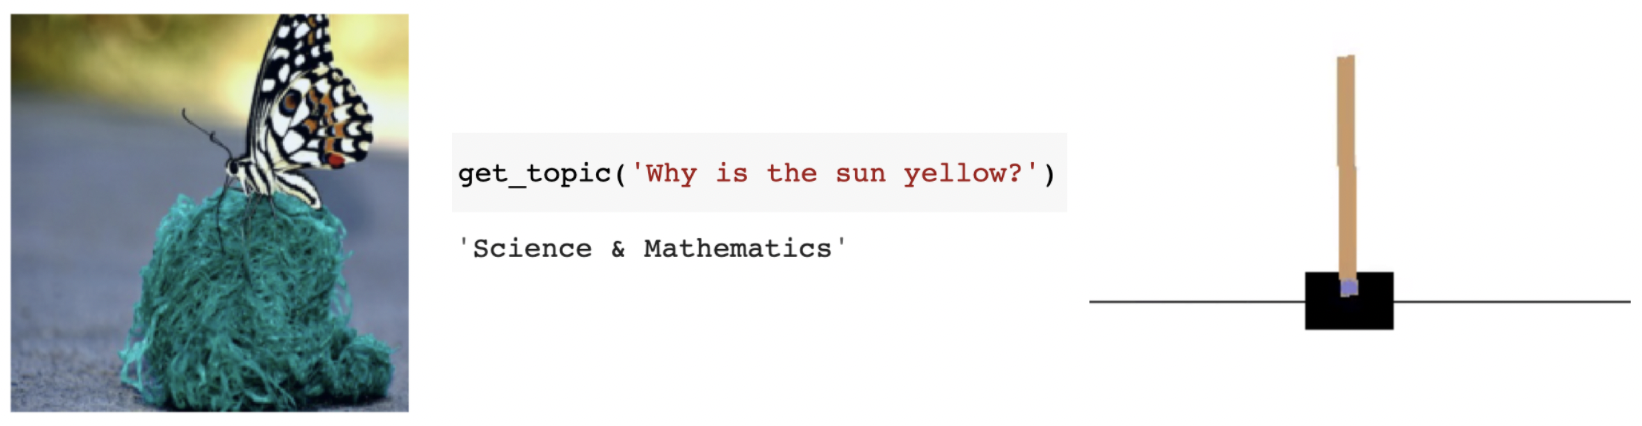

# 0. ✍️ The `wandb` Library 

When working directly with the `wandb` library,
the functions you'll use most often are:


- `wandb.login` - Login to W&B at the start of your session
- [`wandb.init`](https://docs.wandb.ai/guides/track/launch) - Initialise a new W&B, returns a "run" object
- [`wandb.log`](https://docs.wandb.ai/guides/track/log) - Add information to the logs for your run

Most of the code in this notebook is for setting up and executing
our ML experiments and is not specific to experiment tracking with W&B.
To see where W&B is added in the code below you can search for these functions in the notebook or look for the ✍️ emoji. 

When a W&B run begins, a link labeled **Run Page**
will be printed to the standard out.
This link will take you to a W&B
[dashboard](https://docs.wandb.ai/ref/app/pages/run-page)
where you can view live, interactive charts
and information about your experiment.

## Data & Privacy
We take security seriously, and our cloud-hosted dashboard uses industry best practices for encryption. If you're working with datasets that cannot leave your enterprise cluster, we have [on-prem](https://docs.wandb.com/self-hosted) installations available. It's also easy to download all your data and export it to other tools, for example, for custom analysis in a Jupyter notebook. Here's more on our [API](https://docs.wandb.com/library/api).



## Creating a W&B Account, Importing Libraries, and Logging in
[Create an account](http://wandb.ai/login?signup=true), then run the following code cell to install `wandb` and log in.

In [ ]:
!pip install timm fastprogress transformers datasets -Uqqq
!pip install wandb --upgrade -Uqqq

from IPython.display import clear_output
clear_output()

In [ ]:
import copy
import os
from os import listdir
from os.path import isfile, join
import time

from fastprogress.fastprogress import master_bar, progress_bar
import numpy as np
import pandas as pd
import PIL
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

✍️ Login to wandb 

In [ ]:
import wandb
wandb.login()

# 1.  👓 Computer Vision - Fine-tune MobileNet with W&B and PyTorch

First, we'll see an example of image classification
on a super-mini version of the
[iNaturalist 2021 dataset](https://www.kaggle.com/c/inaturalist-2021)
using a [`mobilenet-V3` model](https://pytorch.org/vision/stable/_modules/torchvision/models/mobilenetv3.html)
from the
[PyTorch IMage Models, or "`timm`" library](https://github.com/rwightman/pytorch-image-models).

**Credit:** This code based on the official PyTorch tutorial
[here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

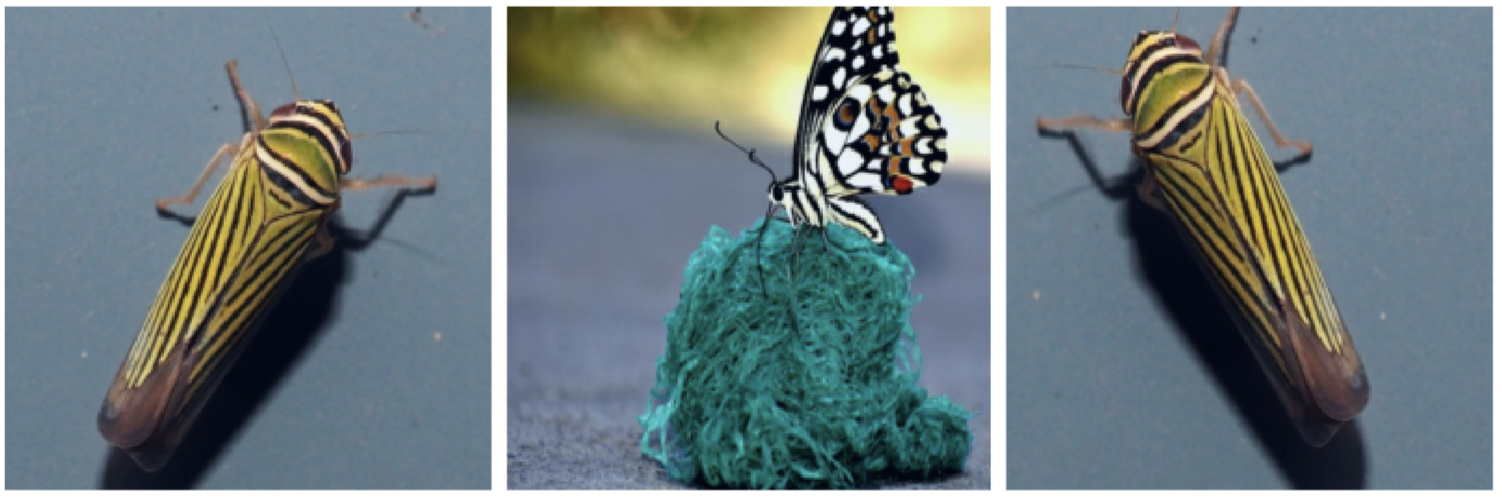

## Download Data from W&B Artifacts

We use W&B Artifacts to download the super-mini iNaturalist 2021 dataset, a subset of the [iNaturalist 2021 dataset](https://www.kaggle.com/c/inaturalist-2021) with only 50 classes with 50 examples each.

W&B Artifacts is a versioning system for
models, datasets, and other large files.
Read more in our [docs here](https://docs.wandb.ai/guides/artifacts).

In [ ]:
# ✍️ Start a wandb run and add any additional info you'd like to the config  
WANDB_CV_PROJECT = "iNat2021"
run = wandb.init(project=WANDB_CV_PROJECT)  # config is optional here

# ✍️ Identify the W&B Artifact where the dataset is stored and download it
artifact = run.use_artifact("wandb/iNat2021/data_supermini_iNat2021:v1", type="dataset")
data_dir = artifact.download()

# ✍️ Close your W&B Run
run.finish()

## Setup Data and DataLoaders

The following cells are boilerplate that
defines our dataset and how it should be loaded off disk.
No Weights & Biases-specific code here
-- you can just execute and move to the next section.

In [ ]:
labels_csv_pth = "supertiny_data/supertiny_data.csv"
data = pd.read_csv(f"{data_dir}/{labels_csv_pth}")

N_CLASSES = data.category_id.nunique()
BS, N_EPOCHS, LR = 128, 10, 0.003

In [ ]:
# Define the Dataset

class INatDataset(Dataset):
  def __init__(self, data_dir, labels_csv_pth, is_train=True, transform=None):
    self.data_dir = data_dir
    self.all_data = pd.read_csv(f"{data_dir}/{labels_csv_pth}")
    self.cat_ids = self.all_data["category_id"].unique()
    
    if is_train: self.data = self.all_data.loc[self.all_data.is_train == 1]
    else: self.data = self.all_data.loc[self.all_data.is_train == 0]
    
    self._setup_files()
    self._setup_data()
    self.file_path_col = self.data.columns.get_loc("file_path")
    self.file_name_col = self.data.columns.get_loc("file_name")
    self._do_cat2label()
    self.transform = transform

  def _setup_files(self):
    self.file_list = [join(self.data_dir, f) for f in listdir(self.data_dir) if 
                      (isfile(join(self.data_dir, f)) and f.endswith("jpg"))]
    self.file_names = [f_path.split("/")[-1] for f_path in self.file_list]
    self.files_df = pd.DataFrame({"file_path": self.file_list, "f_name":self.file_names})

  def _setup_data(self):
    self.data = pd.merge(self.files_df, self.data, left_on="f_name", right_on="file_name")
    self.data.drop(columns=["f_name"])

  def _do_cat2label(self):
    self.cat2label = {}
    idx = 0
    for c in self.cat_ids:
      if c not in self.cat2label:
        self.cat2label[c]=idx
        idx += 1

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    f_path = self.data.iloc[idx, self.file_path_col]
    fn = self.data.iloc[idx, self.file_name_col]
    cat = int(self.data.loc[self.data.file_name == fn, "category_id"].values)
    label = torch.tensor([self.cat2label[cat]])
    
    X = PIL.Image.open(f_path)
    if self.transform is not None:
      X = self.transform(X)
    return {"image":X, "label": label}
    
# Define transforms to apply to our data during training and validation

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Construct the datasets

train_dataset = INatDataset(data_dir, labels_csv_pth, 
                            is_train=True, transform=data_transforms["train"])
val_dataset = INatDataset(data_dir, labels_csv_pth, 
                          is_train=False, transform=data_transforms["val"])

dataset_lens = {"train":len(train_dataset), "val":len(val_dataset)}

In [ ]:
# Create DataLoaders

train_dataloader = DataLoader(
    train_dataset, batch_size=BS, shuffle=True, num_workers=2)
val_dataloader = DataLoader(
    val_dataset, batch_size=2 * BS, shuffle=False, num_workers=2)

dataloaders = {"train": train_dataloader, "val": val_dataloader}
clear_output()

## Train the Model

The cell below defines our entire training setup.

First, we define and download the model,
then set up its optimizer.

Finally, we define the model training logic --
and that's where we integrate the `wandb` code
for logging metrics and more during training.

In [ ]:
import timm
from torch.optim import lr_scheduler, AdamW

# Fetch the model and pretrained weights from timm

model = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=N_CLASSES)

clear_output()

# Set up the optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, betas=(0.9, 0.999), 
                              eps=1e-08, weight_decay=0.01)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                steps_per_epoch=len(dataloaders["train"]), 
                                                epochs=N_EPOCHS)

# Define the training loop

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    model.to(device)
    mb = master_bar(range(num_epochs))
    for epoch in mb:
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train": model.train()  # Set model to training mode
            else: model.eval()   # Set model to evaluate mode

            running_loss, running_corrects = 0.0, 0

            # Iterate over data
            for b_idx, batch in enumerate(progress_bar(dataloaders[phase], parent=mb)):
                inputs = batch["image"].to(device)
                labels = batch["label"].to(device)
                labels = labels.squeeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    # forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                      # ✍️ Log your loss for this step to wandb
                      log_dict = {f"{phase}/loss": loss}

                      # ✍️ Occasionally log 10 images from this batch for inspection 
                      if (b_idx % 50 == 0):
                        log_dict[f"{phase}/train_examples"] = [wandb.Image(i) for i in inputs[:10]]
                    
                      # ✍️ Log to W&B 
                      wandb.log(log_dict)

                    if phase == "train":
                        # backward pass + optimize
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train": scheduler.step()

            epoch_loss = running_loss / dataset_lens[phase]
            epoch_acc = running_corrects.double() / dataset_lens[phase]
            
            # ✍️ Log validation metrics to W&B 
            if phase == "val":
              wandb.log({f"{phase}/accuracy": epoch_acc, f"{phase}/loss": epoch_loss})
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print()

    # ✍️ Log your final accuracy as a summary metric 
    wandb.run.summary["final_accuracy"] = epoch_acc
    wandb.run.finish()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return model
    


**✍️ Start a `wandb` Run**

Here, we inititalize a `wandb` run,
log the hyperparameters,
and start tracking the model's gradients with `wandb.watch`.

In [ ]:
BS = 128
N_EPOCHS = 10 
LR = 0.003

run = wandb.init(project=WANDB_CV_PROJECT, config={"lr": LR, "batch_size": BS, "n_epochs": N_EPOCHS}) 

# Start tracking your model's gradients
wandb.watch(model);

**Start Training** 

Training may take several minutes,
but you can watch your metrics stream in **live**
at the Run Page link produced by the cell above.

In [ ]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=N_EPOCHS)

In [ ]:
# Clear GPU memory in preparation for next model training

import gc
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()

## Bonus: Object Detection with YOLOv5 and W&B
- Interested in object detection? You're in luck! Check out our [YOLOv5 integration here](https://wandb.ai/cayush/yolov5-dsviz-demo/reports/Object-Detection-with-YOLO-and-Weights-Biases--Vmlldzo0NTgzMjk?galleryTag=computer-vision).

# 2. 📜 Natural Language Processing - Fine-tune a BERT Model with W&B and Hugging Face

In this example,
we will use [Hugging Face](https://huggingface.co/)
to fine-tune a [distilled version of the BERT model](https://huggingface.co/distilbert-base-uncased)
for topic classification using the
[Yahoo! Answers dataset](https://huggingface.co/datasets/viewer/?dataset=yahoo_answers_topics).

To learn more about the HuggingFace W&B integration see
[our docs](https://docs.wandb.ai/integrations/huggingface). 

## Setup `wandb`

**✍️  `wandb` Environment Variables**

The easiest way to configure the W&B integration with Hugging Face
is by setting the values of certain environment variables.

Here we will define the project to which
we'll log our results and upload our model.
See the [docs](https://docs.wandb.ai/integrations/huggingface)
for more on how to configure the Hugging Face integration.


In [ ]:
os.environ["WANDB_LOG_MODEL"] = "true"

## Setup Data and DataLoaders

The following cell is boilerplate that
defines our dataset and how it should be loaded off disk.
No Weights & Biases-specific code here
-- you can just execute and move to the next section.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the ~1GB Yahoo! Answers dataset
dataset = load_dataset("yahoo_answers_topics")

# Select just a subset of the dataset for this demo
dataset["train"] = dataset["train"].select(list(range(40000)))
dataset["test"] = dataset["test"].select(list(range(5000)))

# Extract topics
label_list = dataset["train"].flatten_indices().unique("topic")
num_labels = len(label_list)

# Rename a column
dataset["train"].rename_column_("topic", "labels")
dataset["test"].rename_column_("topic", "labels")

clear_output()

# Tokenize the text

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
dataset = dataset.map(lambda x: tokenizer(x["question_title"], truncation=True), batched=True)
clear_output()

## Train the Model

In the following cell,
we use the Hugging Face
[`transformers`](https://huggingface.co/transformers/)
and [`datasets`](https://huggingface.co/docs/datasets/)
libraries to set up our training and logging
and to download the pretrained model.

In [ ]:
from datasets import load_metric
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

# Define the TrainingArguments to configure training

args = TrainingArguments(
    report_to="wandb",                     # ✍️ enable logging to W&B 
    output_dir="topic_classification",     # output directory
    overwrite_output_dir=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    learning_rate=1e-4,
    logging_steps=25,                      # do logging every 25 steps
    evaluation_strategy="steps",         # calculate eval metrics based on steps, not epochs
    eval_steps=100,                      # calculate eval metrics every 100 steps
    load_best_model_at_end=True,
    save_total_limit=3,
    metric_for_best_model="accuracy",
)

# Define our evaluation metric and a helper function

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # metrics from the datasets library have a `compute` method
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Download a pretrained model from Hugging Face

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           num_labels=num_labels)
clear_output()

**✍️ Start a `wandb.Run`**


In [ ]:
WANDB_HF_PROJECT = "yahoo_answers_topics"
run = wandb.init(project=WANDB_HF_PROJECT, name="yahoo_training")

trainer = Trainer(
    model=model,                  # model to be trained
    args=args,                    # training args
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,            # for padding batched data
    compute_metrics=compute_metrics # for custom metrics
)

**Start Training**

Training may take several minutes,
but you can watch your metrics stream in **live**
at the 🚀 link produced by the cell above
once training starts.

In [ ]:
trainer.train()

wandb.finish()

**Test the Predictions**

In [ ]:
def get_topic(sentence, tokenize=tokenizer, model=model):
    # tokenize the input
    inputs = tokenizer(sentence, return_tensors="pt")
    # ensure model and inputs are on the same device (GPU)
    inputs = {name: tensor.cuda() for name, tensor in inputs.items()}
    model = model.cuda()
    # get prediction - 10 classes un-normalized probabilities
    with torch.no_grad():
        predictions = model(**inputs)[0].cpu().numpy()
    # get the top prediction class and convert it to its associated label
    top_prediction = predictions.argmax().item()
    return dataset["train"].features["labels"].int2str(top_prediction)

In [ ]:
get_topic("Why is cheese so much better with wine?")

In [ ]:
# Clear GPU memory in preparation for next model training
import gc
del model
del trainer
gc.collect()
torch.cuda.empty_cache()

# 3. 🤖 Reinforcement Learning - Train a Simple Agent with W&B, Keras, and OpenAI Gym

In this section,
we train a [Keras-RL2](https://github.com/wau/keras-rl2)
model to solve
[Cartpole](https://gsurma.medium.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288),
a classic introductory RL problem, using
[OpenAI Gym](https://gym.openai.com/).

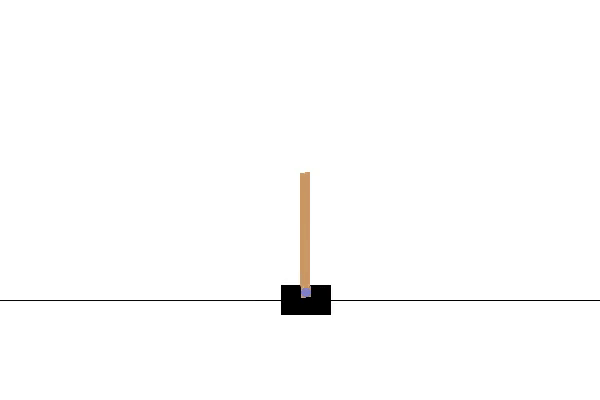

In [ ]:
!pip install -qU wandb

In [ ]:
# install dependencies
!pip install --upgrade "gym[all]" -Uqqq  # install OpenAI RL Gym 🏋‍♀️
!pip install keras-rl2 -Uqqq # install rl framework on top of Keras 🥕

In [ ]:
# import from stdlib -- mostly for videos
import base64
import glob
import io
import os
import timeit
import warnings

# Yes, this is also for videos!
from IPython.display import HTML
from IPython.display import display

# OpenAI Gym 🏋‍♀️
import gym

# Keras, TensorFlow, Numpy
import wandb
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# keras-rl2 framework
import rl
import rl.agents
import rl.memory
import rl.policy

clear_output()

## Setup Data and DataLoaders

Tools for Rendering OpenAI Gym Videos in Colab

In [ ]:
# starting a fake screen in the background
#  in order to render videos
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ["DISPLAY"] = ":1"

# utility to get video file from directory
def get_video_filename(dir="video"):
  glob_mp4 = os.path.join(dir, "*.mp4") 
  mp4list = glob.glob(glob_mp4)
  assert len(mp4list) > 0, "couldnt find video files"
  return mp4list[-1]

✍️ Integrating W&B with Keras-RL - WandB Test Logger 

In [ ]:
class WandbTrainLogger(rl.callbacks.TrainEpisodeLogger):
    def __init__(self, env, **kwargs):
        kwargs = {
            "project": "cartpole",
            **kwargs
        }
        self.wandb_kwargs = kwargs
        super().__init__()

    def init_logging(self):
      # ✍️ Initialize your wandb run 
      return wandb.init(**self.wandb_kwargs)

    # at the start of training, we start up wandb
    def on_train_begin(self, logs):
        if wandb.run is None:
          # ✍️ Initialize your wandb run and log configs 
          self.init_logging()
          wandb.config.update({"env.spec": env.spec.__dict__,
                              })
          wandb.config.update({
              "params": self.params,
              "agent": self.model.__dict__
          })
        super().on_train_begin(logs)

    # when an episode finishes, we log its stats
    def on_episode_end(self, episode, logs):
        duration = timeit.default_timer() - self.episode_start[episode]
        episode_steps = len(self.observations[episode])
        metrics_dict = self.build_metrics_dict(np.array(self.metrics[episode]))
        # ✍️ Log your metrics to wandb 
        wandb.log({
            # duration and timing metadata
            "step": self.step,
            "episode": episode + 1,
            "duration": duration,
            "episode_steps": episode_steps,
            "sps": float(episode_steps) / duration,

            # reward stats
            "episode_reward": np.sum(self.rewards[episode]),
            "reward_mean": np.mean(self.rewards[episode]),
            "reward_min": np.min(self.rewards[episode]),
            "reward_max": np.max(self.rewards[episode]),

            # action and observation stats
            "action_mean": np.mean(self.actions[episode]),
            "action_min": np.min(self.actions[episode]),
            "action_max": np.max(self.actions[episode]),
            "obs_mean": np.mean(self.observations[episode]),
            "obs_min": np.min(self.observations[episode]),
            "obs_max": np.max(self.observations[episode]),
            **metrics_dict
        })

        # clean up after ourselves
        del self.episode_start[episode]
        del self.observations[episode]
        del self.rewards[episode]
        del self.actions[episode]
        del self.metrics[episode]

    # building dict of metric means in a super robust way
    def build_metrics_dict(self, metrics):
        metrics_dict = {}
        with warnings.catch_warnings():
            warnings.filterwarnings("error")
            for idx, name in enumerate(self.metrics_names):
                try:
                    metrics_dict[name] = np.nanmean(metrics[:, idx])
                except Warning:
                    metrics_dict[name] = float("nan")
        return metrics_dict

WandB Test Logger

In [ ]:
class WandbTestLogger(rl.callbacks.TestLogger):
    def __init__(self, env, **kwargs):
        kwargs = {
            "project": "cartpole",
            **kwargs
        }
        self.wandb_kwargs = kwargs

        self.env = env
        self.rewards = {}
        self.env.env.theta_threshold_radians = np.pi / 2

    def init_logging(self):
      # ✍️ Initialize wandb logging 
      return wandb.init(**self.wandb_kwargs)

    # at the start of testing, we start up wandb
    def on_train_begin(self, logs):
        # ✍️ Initialize your wandb run and log configs 
        if wandb.run is None:
          self.init_logging()
          wandb.config.update(env_dict)
          wandb.config.update({
              "params": self.params,
              "agent": self.model.__dict__,
          })

        super().on_train_begin(logs)

    def on_episode_end(self, episode, logs):
        """ Compute and log training statistics of the episode when done """
        super().on_episode_end(episode, logs)

        wandb.summary.update({
          "test_reward": logs["episode_reward"]
        })

        # log gameplay video in wandb
        self.env.close()
        mp4 = get_video_filename()
        wandb.log({"test_gameplay": wandb.Video(mp4, fps=4, format="mp4")})

Setup Gym Environment

In [ ]:
# First, we build the environment
ENV_NAME = "CartPole-v1"

# Get the environment
env = gym.make(ENV_NAME)
env.env.theta_threshold_radians = np.pi / 4  # extend the angle allowed before failure

Setting Hyperparameters

In [ ]:
config = {}
config["activation"] = "linear"  # what is the activation function of our hidden layer?
config["n_hidden"] = 1  # how many hidden units does that layer have?

# how often do we update the target model,
#  as a fraction of how often we update the online model
config["target_model_update"] = 1.0 
config["lr"] = 1e-10  # learning rate for Adam optimizer

config["nb_steps"] = 500

## Setup Model

In [ ]:
def build_model(config, env):
  model = keras.Sequential()
  model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
  model.add(Dense(config["n_hidden"]))
  model.add(Activation(config["activation"]))
  model.add(Dense(env.action_space.n, activation="linear"))

  return model

In [ ]:
model = build_model(config, env)
model.summary()

Construct an Agent

In [ ]:
# an agent combines a policy and a Q value-predicting network
#  and optionally a memory for replay

def build_dqn_agent(model, config):
  training_policy = rl.policy.EpsGreedyQPolicy()
  test_policy = rl.policy.GreedyQPolicy()
  
  memory = rl.memory.SequentialMemory(limit=50000, window_length=1)
  dqn = rl.agents.dqn.DQNAgent(
      model=model, nb_actions=model.output_shape[-1], memory=memory,
      nb_steps_warmup=10,
      target_model_update=config["target_model_update"],
      policy=training_policy, test_policy=test_policy)
  
  dqn.compile(Adam(lr=config["lr"]), metrics=["mae"])

  return dqn

## Train

Define your train function

In [ ]:
def train(config, env, verbosity=2):
  # set up our training and testing loggers
  train_logger = WandbTrainLogger(env, project="cartpole",
                                  job_type="train", config=config)
  test_logger = WandbTestLogger(env)

  # tell wandb we're ready to go!
  with train_logger.init_logging() as run:
    if verbosity > 1:  # describe the environment if at high verbosity
      print(env.spec.__dict__)  # this gets logged to W&B too!

    model = build_model(wandb.config, env)
    if verbosity:  # summarize the model's contents if non-zero verbosity
      model.summary()  # this gets logged to W&B too!
    
    agent = build_dqn_agent(model, wandb.config)
    # call .fit on the agent
    agent.fit(env, nb_steps=wandb.config["nb_steps"], visualize=False, callbacks=[train_logger])

    # # test the agent once and generate a video
    # test_env = gym.wrappers.Monitor(env, "./video", force=True)
    # agent.test(test_env, visualize=False, verbose=0, callbacks=[test_logger])
  return agent

Train your agent

In [ ]:
dqn = train(config, env)

# ✍️ W&B Best Practices 

1. **Projects**: Log multiple runs to a project to compare them. `wandb.init(project="project-name")`
2. **Groups**: For multiple processes or cross validation folds, log each process as a runs and group them together. `wandb.init(group="experiment-1")`
3. **Tags**: Add tags to track your current baseline or production model.
4. **Notes**: Type notes in the table to track the changes between runs.
5. **Reports**: Take quick notes on progress to share with colleagues and make dashboards and snapshots of your ML projects.

# ✍️ W&B Advanced Setup 
1. [Environment variables](https://docs.wandb.com/library/environment-variables): Set API keys in environment variables so you can run training on a managed cluster.
2. [Offline mode](https://docs.wandb.com/library/technical-faq#can-i-run-wandb-offline): Use `dryrun` mode to train offline and sync results later.
3. [On-prem](https://docs.wandb.com/self-hosted): Install W&B in a private cloud or air-gapped servers in your own infrastructure. We have local installations for everyone from academics to enterprise teams.
4. [Sweeps](https://docs.wandb.com/sweeps): Set up hyperparameter search quickly with our lightweight tool for tuning.
5. [Artifacts](https://docs.wandb.com/artifacts): Track and version models and datasets in a streamlined way that automatically picks up your pipeline steps as you train models.